In [31]:
import requests
import pickle
import time


## Получаем пользователей

In [116]:
token = "..."

In [27]:
def get_offset(group_id):
    count = requests.get(
        "https://api.vk.com/method/groups.getMembers",
        params={
            "access_token": token,
            "v": 5.103,
            "group_id": group_id,
            "sort": "id_desc",
            "offset": 0,
            "fields": "last_seen",
        },
    ).json()["response"]["count"]
    return count // 1000


def get_users(group_id):
    good_id_list = []
    offset = 0
    response = requests.get(
        "https://api.vk.com/method/groups.getMembers",
        params={
            "access_token": token,
            "v": 5.103,
            "group_id": group_id,
            "sort": "id_desc",
            "offset": offset,
            "fields": "last_seen",
        },
    ).json()["response"]
    offset += 1
    for item in response["items"]:
        try:
            if item["last_seen"]["time"] >= 1605571200:
                good_id_list.append(item["id"])
        except Exception as E:
            continue
    return good_id_list


In [29]:
group_list = ["itmo_negotiations", "t3abtpa"]

group_users_dict = {}

for group in group_list:
    print(group)
    try:
        users = get_users(group)
        group_users_dict[group] = users
        time.sleep(1)
    except KeyError as E:
        print(group, E)
        continue

with open("group_users_dict", "wb") as f:
    pickle.dump(group_users_dict, f)


itmo_negotiations
t3abtpa


In [34]:
users_negotiation = group_users_dict["itmo_negotiations"]
users_theater = group_users_dict["t3abtpa"]

users_intersection = set(users_theater) & set(users_negotiation)
print(f"Кол-во людей в группе театра миниатюр: {len(users_theater)}")
print(f"Кол-во людей в группе переговоров : {len(users_negotiation)}")
print(f"Кол-во пользователей в обоих группах: {len(users_intersection)}")


Кол-во людей в группе театра миниатюр: 926
Кол-во людей в группе переговоров : 883
Кол-во пользователей в обоих группах: 119


## Получаем посты

In [45]:
def get_vk_group_posts(group_id, max_posts=2000):
    url = "https://api.vk.com/method/wall.get"

    params = {"owner_id": group_id, "access_token": token, "v": "5.131", "count": 100}

    posts = []
    offset = 0

    # Fetch posts until we reach the maximum number of posts
    posts_in_group = None
    while len(posts) < max_posts:
        params["offset"] = offset  # Update offset for each batch
        response = requests.get(url, params=params).json()

        # Check for errors in response
        if "error" in response:
            print("Error fetching posts:", response["error"])
            break
        if posts_in_group is None:
            posts_in_group = response["response"]["count"]
        items = response["response"]["items"]
        posts.extend(items)

        offset += 100  # Increment offset

        if offset >= posts_in_group:
            break

    posts = posts[:max_posts]
    return posts, posts_in_group


group_posts_dict = {}

for group in group_list:
    print(group)
    try:
        posts = get_vk_group_posts(group)
        group_posts_dict[group] = posts
        time.sleep(1)
    except KeyError as E:
        print(group, E)
        continue

with open("group_posts_dict.pickle", "wb") as f:
    pickle.dump(group_posts_dict, f)


itmo_negotiations
t3abtpa


## Обрабатываем тексты и строим облака слов

### Предобработка

Получаем тексты из постов

In [54]:
group_texts_dict = {}
for group, posts in group_posts_dict.items():
    # тут мой косяк
    posts = posts[0]
    texts = [post["text"] for post in posts]
    group_texts_dict[group] = texts

with open("group_texts_dict.pickle", "wb") as f:
    pickle.dump(group_texts_dict, f)


Функция для токенизации и приведения к начальной форме

In [56]:
from razdel import tokenize
from nltk.corpus import stopwords
import pymorphy2
from collections import defaultdict


def pymorphy2_311_hotfix():
    from inspect import getfullargspec
    from pymorphy2.units.base import BaseAnalyzerUnit

    def _get_param_names_311(klass):
        if klass.__init__ is object.__init__:
            return []
        args = getfullargspec(klass.__init__).args
        return sorted(args[1:])

    setattr(BaseAnalyzerUnit, "_get_param_names", _get_param_names_311)


pymorphy2_311_hotfix()


def tokenize_and_base(text):
    morph = pymorphy2.MorphAnalyzer()

    russian_stopwords = set(stopwords.words("russian"))
    additional_stopwords = {
        "и",
        "но",
        "я",
        "в",
        "но",
        "что",
        "мой",
        "свой",
        "весь",
        "всё",
        "на",
        "мы",
        "c",
        "a",
        "вест",
        "это",
        "сам",
    }
    russian_stopwords.update(additional_stopwords)
    words = [i.text for i in tokenize(text)]
    processed_words = []
    for word in words:
        # Remove punctuation
        if not word.isalpha():
            continue
        # Remove stopwords
        if word in russian_stopwords:
            continue
        parsed_word = morph.parse(word)[0]
        normal_form = parsed_word.normal_form
        if normal_form in russian_stopwords:
            continue
        processed_words.append(normal_form)
    return processed_words


Получаем словари, где ключь - токен, а значение - кол-во повторений

In [59]:
from tqdm import tqdm

In [62]:
texts = group_texts_dict["itmo_negotiations"]


def count_tokens(texts, description=""):
    count = defaultdict(lambda: 0)
    for text in tqdm(texts, desc=description):
        tokens = tokenize_and_base(text)
        for token in tokens:
            count[token] += 1
    return count


group_cnt_tokens_dict = {}
for group, texts in group_texts_dict.items():
    count = count_tokens(texts, group)
    group_cnt_tokens_dict[group] = count

for group, default_d in group_cnt_tokens_dict.items():
    group_cnt_tokens_dict[group] = dict(default_d)


t3abtpa: 100%|██████████| 780/780 [02:16<00:00,  5.71it/s]


In [68]:
with open("group_cnt_token_dict.pickle", "wb") as f:
    pickle.dump(group_cnt_tokens_dict, f)


### Строим облака слов

In [90]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def create_wordcloud(token_cnt, group_name):
    # Generate a word cloud image
    wordcloud = WordCloud(
        width=1920, height=1080, background_color="white"
    ).generate_from_frequencies(token_cnt)

    # Display the word cloud image
    plt.figure(figsize=(10, 5), dpi=200)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {group_name}")
    plt.show()

    # Save the word cloud image
    wordcloud.to_file(f"{group_name}_wordcloud.png")


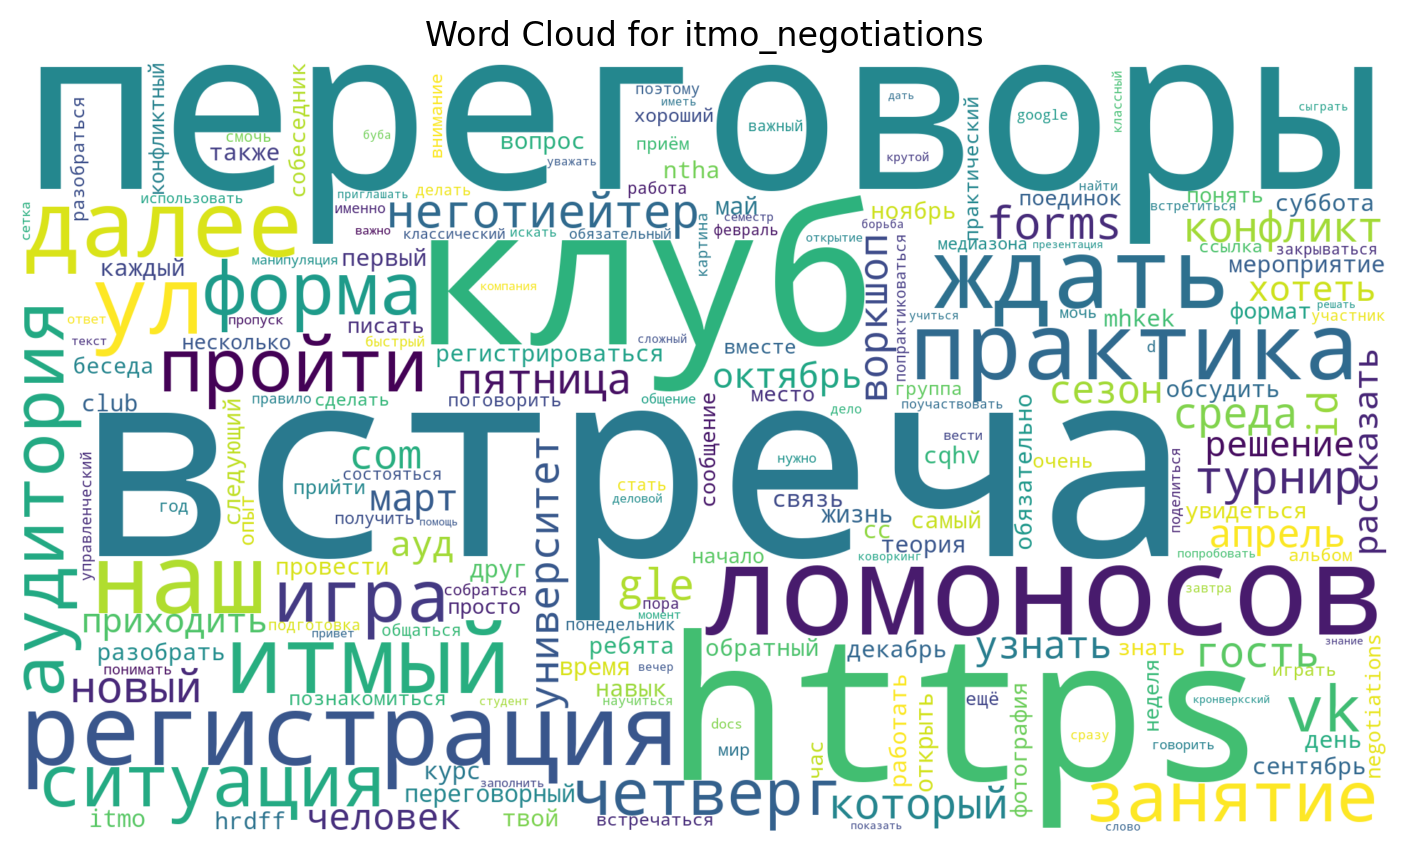

In [91]:
create_wordcloud(group_cnt_tokens_dict["itmo_negotiations"], "itmo_negotiations")

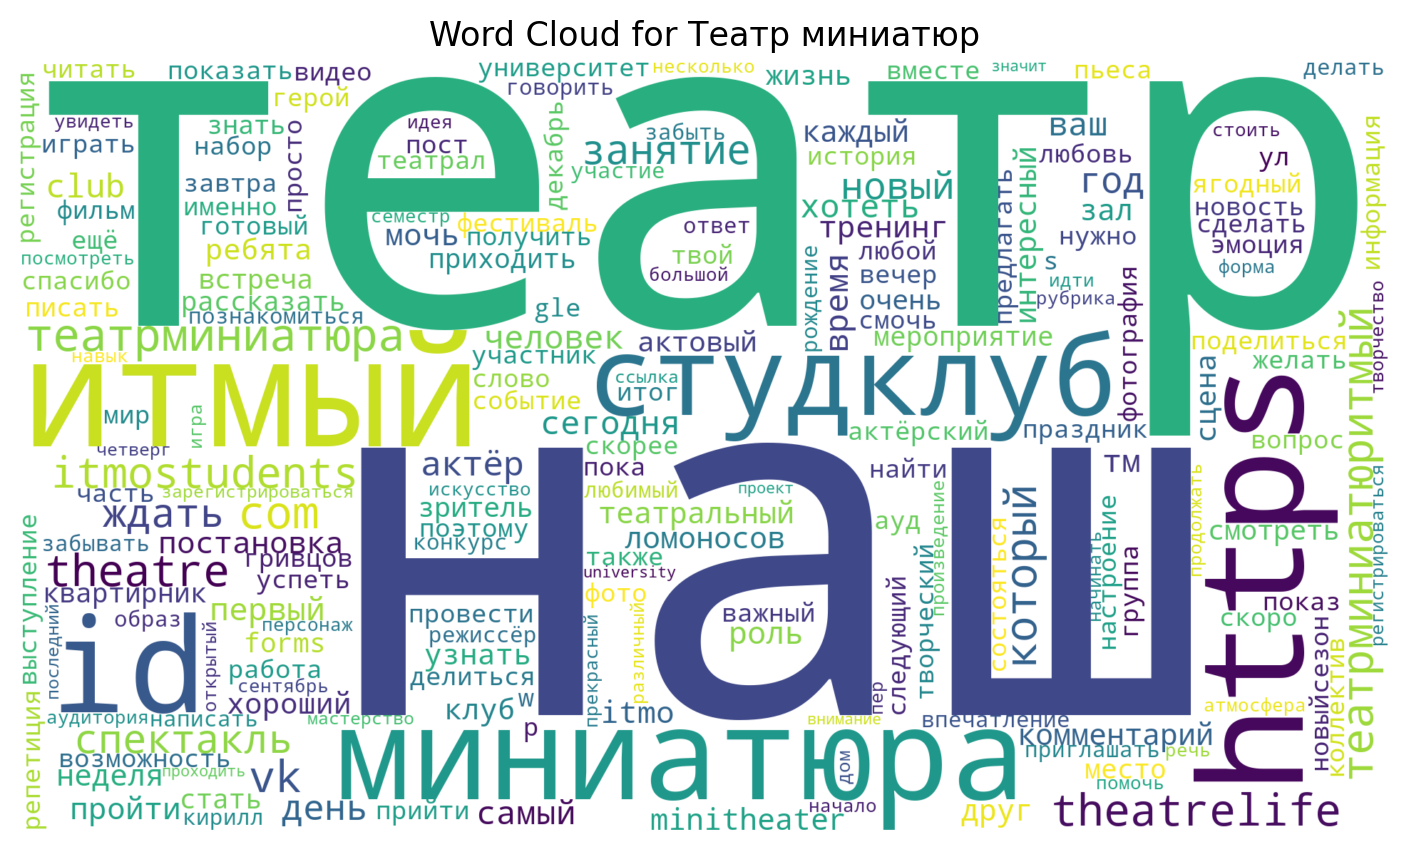

In [86]:
create_wordcloud(group_cnt_tokens_dict["t3abtpa"], "Театр миниатюр")

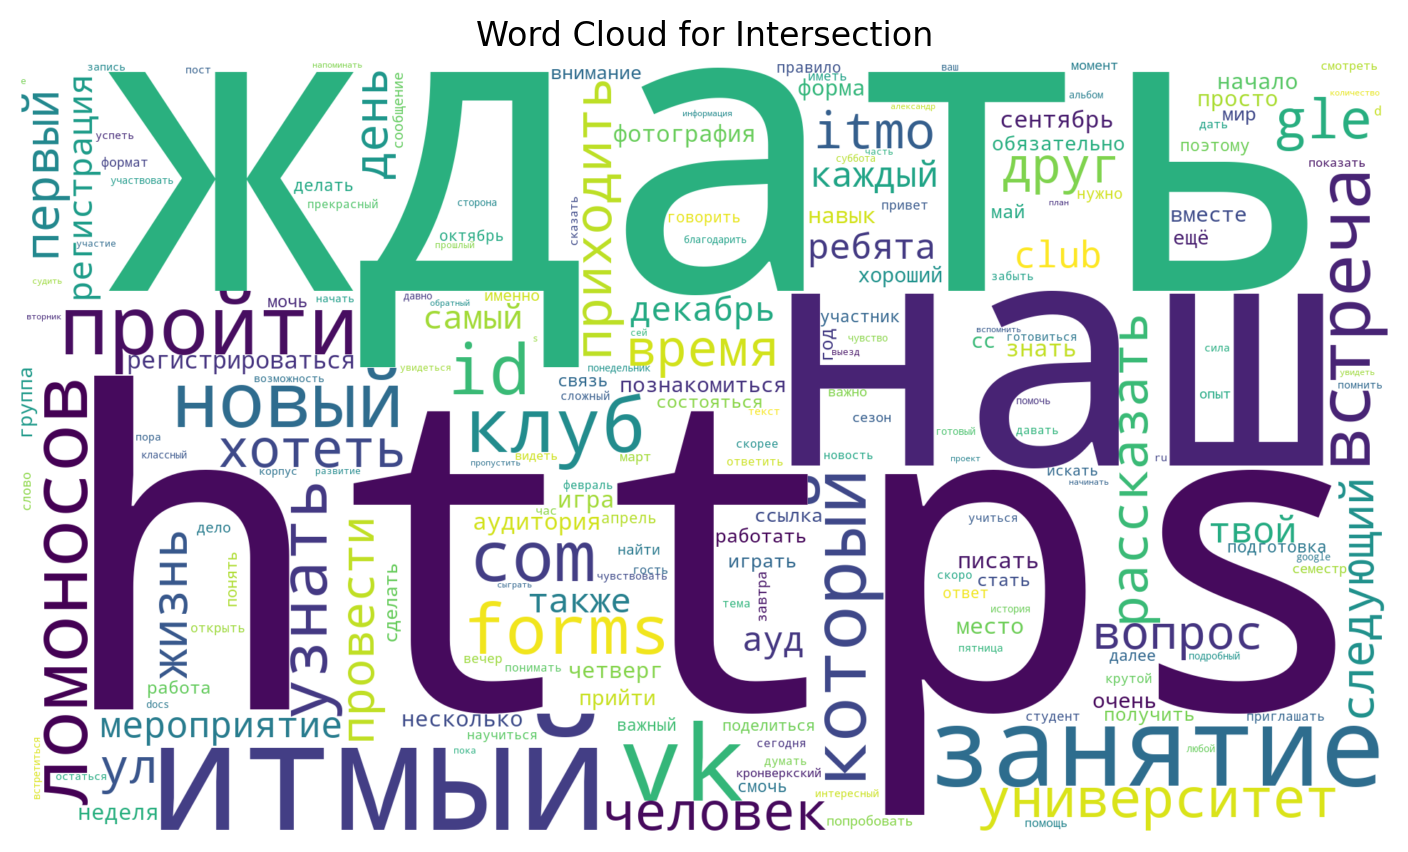

In [355]:
intersections = defaultdict(lambda: 0)
fists = group_cnt_tokens_dict["itmo_negotiations"]
second = group_cnt_tokens_dict["t3abtpa"]

for token, cnt1 in fists.items():
    if token in second:
        cnt2 = second[token]
        cnt_min = min(cnt1, cnt2)
        intersections[token] = cnt_min
create_wordcloud(intersections, "Intersection")


## Анализируем время постов

In [108]:
from collections import Counter
from datetime import datetime


def get_count_hours(posts):
    dates = [post["date"] for post in posts]
    hours = [datetime.fromtimestamp(date).hour for date in dates]

    # Convert the list of hours into a DataFrame and count occurrences

    hour_counts = Counter(hours)
    return hour_counts


def plot_hour_counts(hour_counts, group_name):
    hours = list(range(0, 24))
    counts = []
    for hour in hours:
        counts.append(hour_counts[hour])

    plt.figure(figsize=(12, 6))
    plt.bar(hours, counts, color="blue", alpha=0.7)
    plt.xlabel("Час")
    plt.ylabel("Количество постов")
    plt.title(f"Активность в {group_name}")
    plt.xticks(range(0, 24))  # Set x-ticks to show every hour
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()
    plt.savefig(f"activity_{group_name}.png")


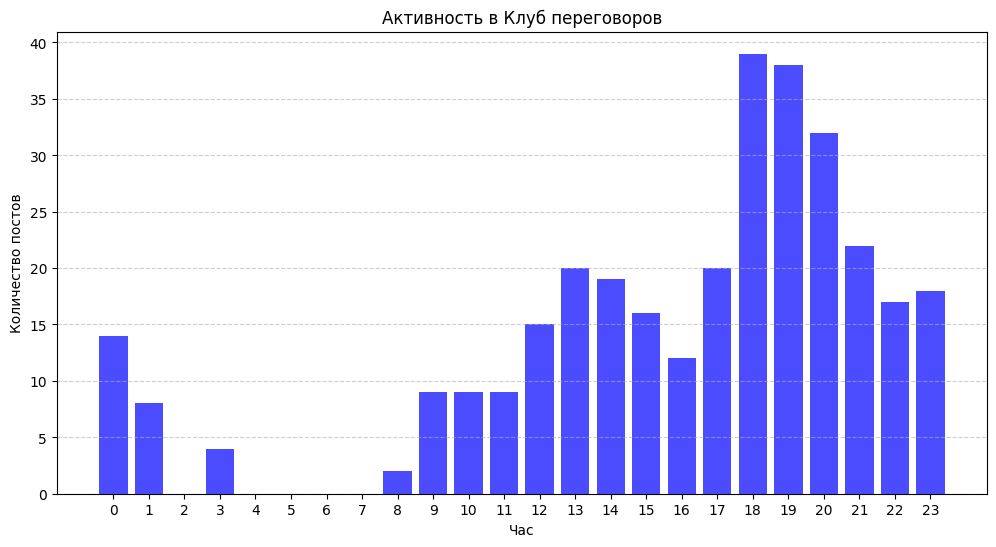

<Figure size 640x480 with 0 Axes>

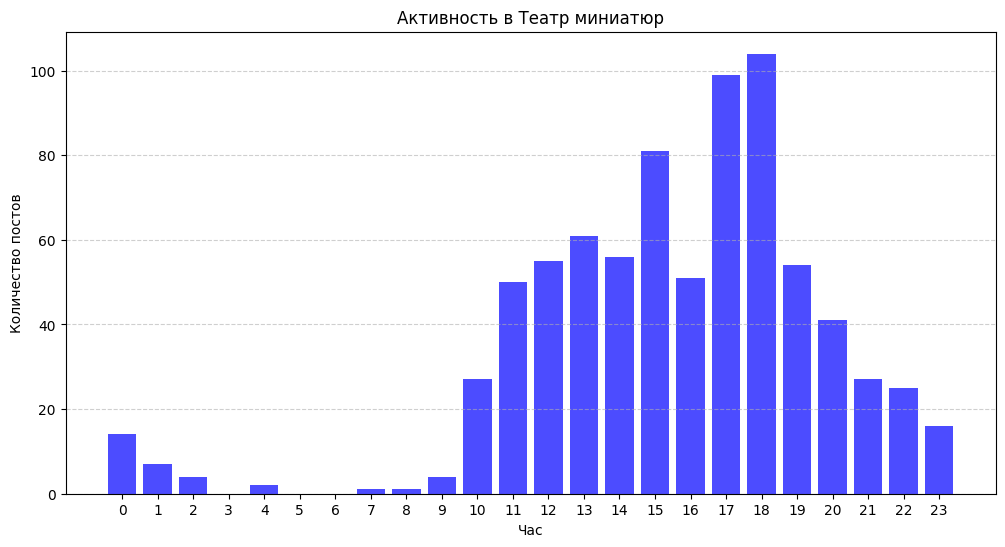

<Figure size 640x480 with 0 Axes>

In [111]:
id_to_name = {"itmo_negotiations": "Клуб переговоров", "t3abtpa": "Театр миниатюр"}
for group, posts in group_posts_dict.items():
    name = id_to_name[group]
    posts = posts[0]
    counts = get_count_hours(posts)
    plot_hour_counts(counts, name)


## Получаем друзей пользователей

Получам друзей из VK

In [131]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming users_negotiation and users_theater are lists of user IDs
users_negotiation = set(users_negotiation)
users_theater = set(users_theater)

# Categories
only_negotiation = users_negotiation - users_theater
only_theater = users_theater - users_negotiation
both_groups = users_negotiation & users_theater


# Define a function to fetch friends (you need to implement the fetching logic based on how you access data)
def fetch_friends(user_id):
    url = "https://api.vk.com/method/friends.get"

    params = {
        "owner_id": user_id,
        "access_token": token,
        "v": "5.131",
    }
    response = requests.get(url, params=params).json()

    if "error" in response:
        print("Error fetching posts:", response["error"])

    return response["response"]["items"]


# Gather all friends for each category
friends_negotiation = {user: fetch_friends(user) for user in only_negotiation}
friends_theater = {user: fetch_friends(user) for user in only_theater}
friends_both = {user: fetch_friends(user) for user in both_groups}





def dump(filename, data):
    with open(filename, "wb") as file:
        pickle.dump(data, file)


dump("friends_graph_negotiation_only.pickle", friends_negotiation)
dump("friends_graph_theater_only.pickle", friends_theater)
dump("friends_graph_in_both.pickle", friends_both)


Фильтруем, чтобы в друзьях были люди только из наших сообществ

In [184]:
relevant_users = users_negotiation | users_theater


filtered_friends_negotiation = {
    k: [f for f in v if f in relevant_users] for k, v in friends_negotiation.items()
}
filtered_friends_theater = {
    k: [f for f in v if f in relevant_users] for k, v in friends_theater.items()
}
filtered_friends_both = {
    k: [f for f in v if f in relevant_users] for k, v in friends_both.items()
}
    

## Строим графы взаимоотношения

### Полезные функции

In [209]:
import numpy as np

In [219]:
def get_mean_std(g):
    degrees = np.array([degree for node, degree in G.degree()])

    # Calculate the mean and standard deviation
    mean_degree = np.mean(degrees)
    std_degree = np.std(degrees)

    return mean_degree, std_degree


def remove_outliers_more(g, n_std):
    mean_degree, std_degree = get_mean_std(g)
    threshold = mean_degree + n_std * std_degree
    nodes_to_remove = [node for node, degree in G.degree() if degree > threshold]
    # Remove these nodes from the graph
    G.remove_nodes_from(nodes_to_remove)
    print(f"removed nodes with more than {threshold} connections")


def remove_outliers_less(g, n_std):
    mean_degree, std_degree = get_mean_std(g)
    threshold = mean_degree + n_std * std_degree
    nodes_to_remove = [node for node, degree in G.degree() if degree < threshold]
    # Remove these nodes from the graph
    G.remove_nodes_from(nodes_to_remove)
    print(f"removed nodes with less than {threshold} connections")


In [250]:
def remove_nodes(G, n_connections, less=True):
    if less:
        nodes_to_remove = [
            node for node, degree in G.degree() if degree < n_connections
        ]
        print(f"removed nodes with degree < {n_connections}")
    else:
        nodes_to_remove = [
            node for node, degree in G.degree() if degree >= n_connections
        ]
        print(f"removed nodes with degree >= {n_connections}")
    G.remove_nodes_from(nodes_to_remove)


In [350]:
class GraphCreator:
    G = None
    categories = ["Only Negotiation", "Only Theater", "Both"]
    nodes = [only_negotiation, only_theater, both_groups]
    edges = [
        filtered_friends_negotiation,
        filtered_friends_theater,
        filtered_friends_both,
    ]

    color_map = {"Only Negotiation": "red", "Only Theater": "green", "Both": "blue"}

    def __init__(self, negotiation=False, theater=False, both=False):
        self.in_graph = [negotiation, theater, both]

    def get_colors(self):
        if self.G is None:
            raise Exception("no graph created")
        node_colors = []
        for node in self.G.nodes(data=True):
            try:
                category = node[1]["category"]
            except KeyError:
                print(node)
                break
            color = self.color_map[category]
            node_colors.append(color)
        return node_colors

    def create_graph(self):
        self.G = nx.Graph()
        self._fill_full_graph()
        self._remove_edges()
        return self.G

    def _fill_full_graph(self):
        for i in range(len(self.categories)):
            category = self.categories[i]
            nodes = self.nodes[i]
            edges = self.edges[i]
            self._add_nodes(nodes, category)
            self._add_edges(edges)
        return self.G

    def _remove_edges(self):
        categories_to_delete = []
        for i in range(len(self.categories)):
            in_graph = self.in_graph[i]
            category = self.categories[i]
            if not in_graph:
                categories_to_delete.append(category)

        nodes = list(self.G.nodes(data=True))
        for node in nodes:
            node_name = node[0]
            category = node[1]["category"]
            if category in categories_to_delete:
                self.G.remove_node(node_name)

    def _add_nodes(self, nodes, category):
        for node in nodes:
            self.G.add_node(node, category=category)

    def _add_edges(self, edges):
        for start, ends in edges.items():
            for end in ends:
                self.G.add_edge(start, end)


### Исследуем граф из всех пользователей

Цветовая палитра:

* Только из переговоров - Красный, 
* Только из театра миниаютр -  зеленый
* Из обоих сообщества - синий}

Количество ребер: 56899
Количество вершин: 1690


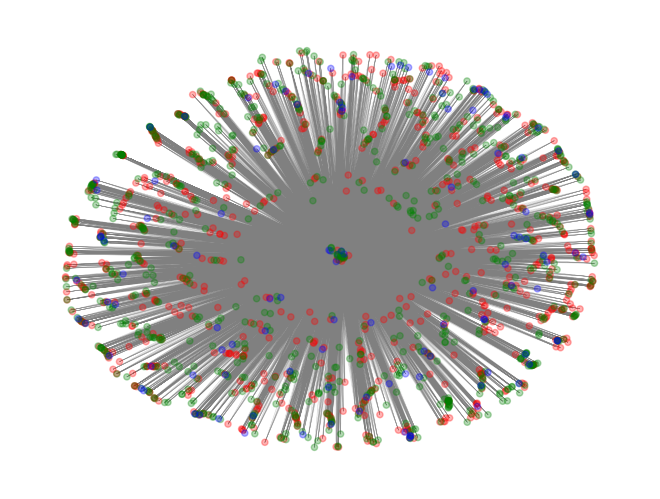

In [354]:
creator = GraphCreator(both=True, theater=True, negotiation=True)

G = creator.create_graph()
node_colors = creator.get_colors()

print(f'Количество ребер: {len(G.edges())}')
print(f'Количество вершин: {len(G.nodes())}')

pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=20,
    width=0.1,
    edge_color="gray",
    alpha=0.3,
)

plt.show()


Уберем ноды с количетсвом связей < 40

removed nodes with degree < 40


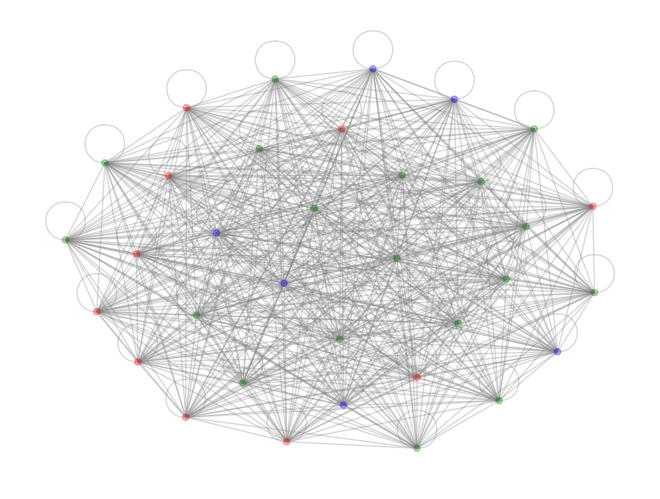

In [290]:
creator = GraphCreator(both=True, theater=True, negotiation=True)

G = creator.create_graph()
remove_nodes(G, 40, less=True)
node_colors = creator.get_colors()


pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=20,
    width=1,
    edge_color="gray",
    alpha=0.3,
)

plt.show()


Уберем ноды с количеством связей >= 40

removed nodes with degree >= 40


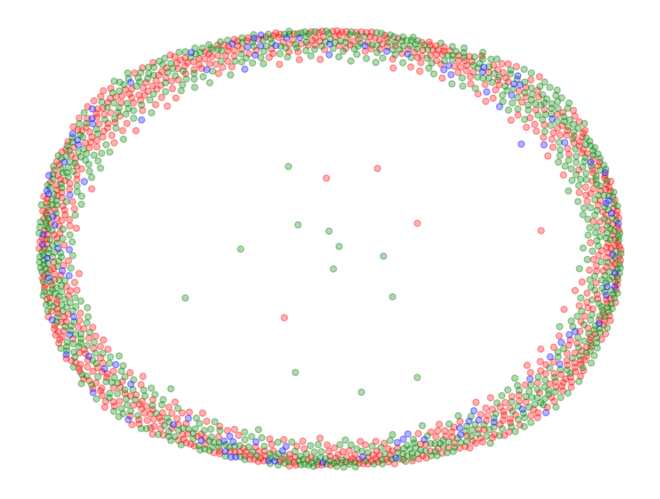

In [291]:
creator = GraphCreator(both=True, theater=True, negotiation=True)

G = creator.create_graph()
remove_nodes(G, 40, less=False)
node_colors = creator.get_colors()


pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=20,
    width=1,
    edge_color="gray",
    alpha=0.3,
)

plt.show()

Видим общий тренд, что пользователи находятся в друзьях у основного костяка,
 но не знакомы между собой. Основной же костяк сильно знаком друг с другом, несмотря 
 на то что это разные сообщества и их тематика не пересекается

### Исследуем взаимоотношения среди пользователей принадлежащим к обоим множествам

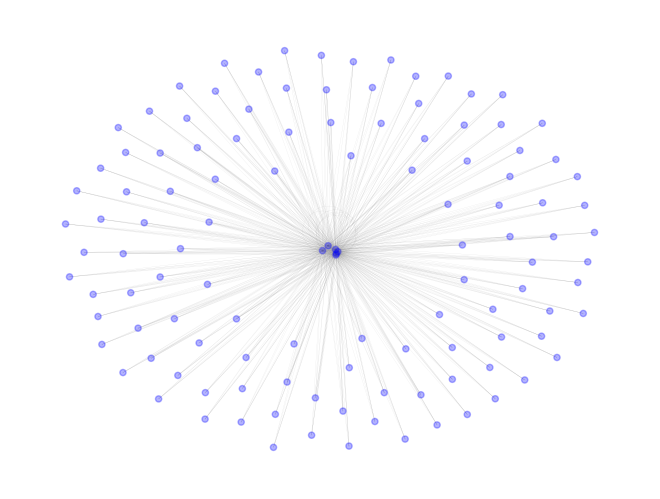

In [212]:
creator = GraphCreator(both=True)

G = creator.create_graph()
node_colors = creator.get_colors()


pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=20,
    width=0.1,
    edge_color="gray",
    alpha=0.3,
)

plt.show()


removed nodes with degree < 7


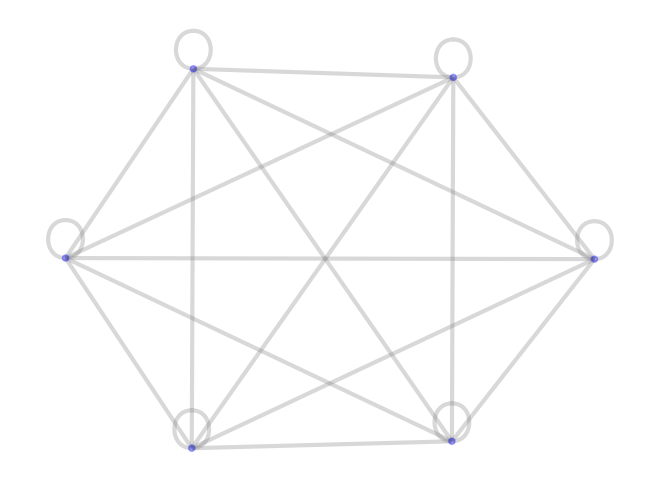

In [287]:
creator = GraphCreator(both=True)

G = creator.create_graph()
remove_nodes(G, 7, less=True)
# remove_outliers_more(G, 1)
node_colors = creator.get_colors()


pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=20,
    width=3,
    edge_color="gray",
    alpha=0.3,
)

plt.show()


removed nodes with degree >= 7


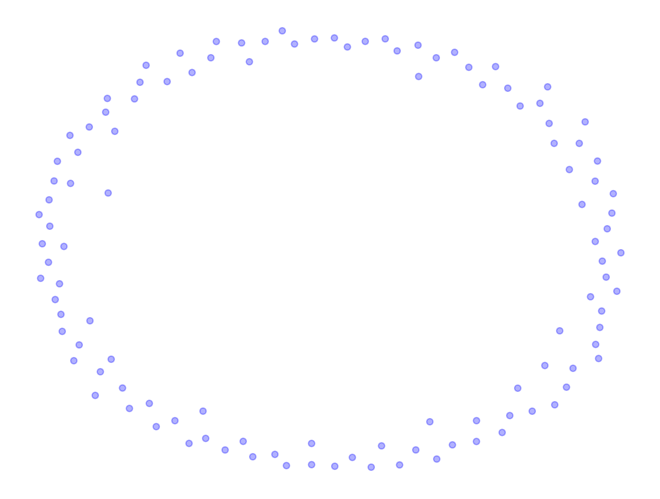

In [292]:
creator = GraphCreator(both=True)

G = creator.create_graph()
remove_nodes(G, 7, less=False)
# remove_outliers_more(G, 1)
node_colors = creator.get_colors()


pos = nx.spring_layout(G)  # Positions for all nodes

nx.draw(
    G,
    pos,
    node_color=node_colors,
    with_labels=False,
    node_size=20,
    width=3,
    edge_color="gray",
    alpha=0.3,
)

plt.show()

### Остальные подмножества

Везде проявляется одинаковая структура

### Вывод

В обоих сообщества проявляется структура, где есть группа самых активных, а остальные знакому только с ними

## Кластеризация

Так как в графе из всех сообществ слишком много вершин, проанализируем граф состоящий только из участников обоих сообществ


Цвет графов:
* Цвет вершины = Цвет сообщества

* Цвет ребра:
  * Если обе вершины принадлежат к одному сообществу, то цвета сообщества
  * Если разного, то черный

### Полезные функции

In [342]:
def reformat_G_and_get_colors(G, communities, cmap='hsv'):
    # Отбираем только ноды которые есть в сообществах
    all_nodes = []
    for community in communities:
        all_nodes.extend(community)
    all_nodes = set(all_nodes)
    # Удаляем ноды, которых нет в сообществах
    nodes = list(G.nodes(data=True))
    for node in nodes:
        name = node[0]
        if name not in all_nodes:
            G.remove_node(name)

    # Number of communities
    num_communities = len(communities)

    # Get colors from the 'hsv' colormap
    colormap = plt.get_cmap(cmap)
    colors = [colormap(i / num_communities) for i in range(num_communities)]

    # Create a color map for nodes
    node_colors = []
    node_community = {}
    for node in G.nodes():
        for i, community in enumerate(communities):
            if node in community:
                node_colors.append(colors[i])
                node_community[node] = i
                break

    edge_colors = []
    for edge in G.edges():
        if node_community[edge[0]] == node_community[edge[1]]:  # Both nodes are in the same community
            edge_colors.append(colors[node_community[edge[0]]])
        else:
            edge_colors.append('black')  # Nodes are in different communities
    return node_colors, edge_colors
    


### Визуализируем сообщества

Количество кластеров: 6


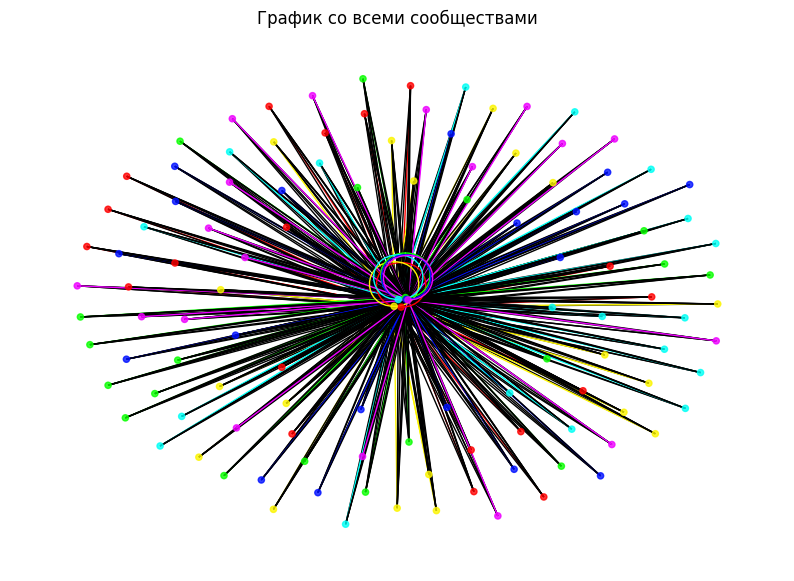

In [344]:
creator = GraphCreator(both=True)
G = creator.create_graph()
communities = list(nx.community.louvain_communities(G))
num_communities = len(communities)
print(f'Количество кластеров: {num_communities}')

node_colors, edge_colors = reformat_G_and_get_colors(G, communities)



plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)
plt.title('График со всеми сообществами')
plt.axis('off');

Выберем только 2 сообщества и посмотрим на визуализацию

Количество кластеров: 2


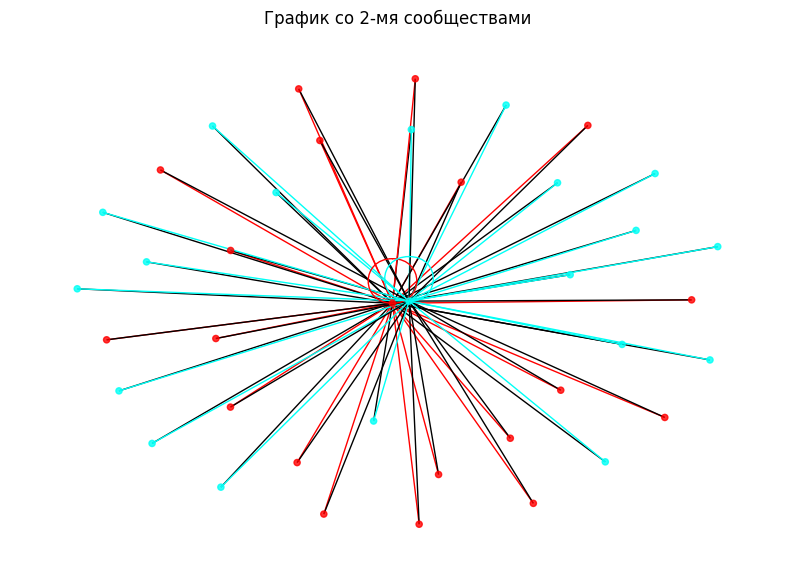

In [346]:
creator = GraphCreator(both=True)
G = creator.create_graph()
communities = list(nx.community.louvain_communities(G))[:2]
num_communities = len(communities)
print(f'Количество кластеров: {num_communities}')

node_colors, edge_colors = reformat_G_and_get_colors(G, communities)



plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)
plt.title('График со 2-мя сообществами')
plt.axis('off');

Видим, что из 2-х случайных сообществ все переферийные вершины связаны сразу с 2-мя центральными. Это говорит о том, что в принципе разделение на сообщества плохо работает на данном графе, потому что все вершины можно разделить на центральные и переферийные. Центральные связаны между собой. Переферийные связаны с центральными

Посмотрим на 3 сообщества

Количество кластеров: 3


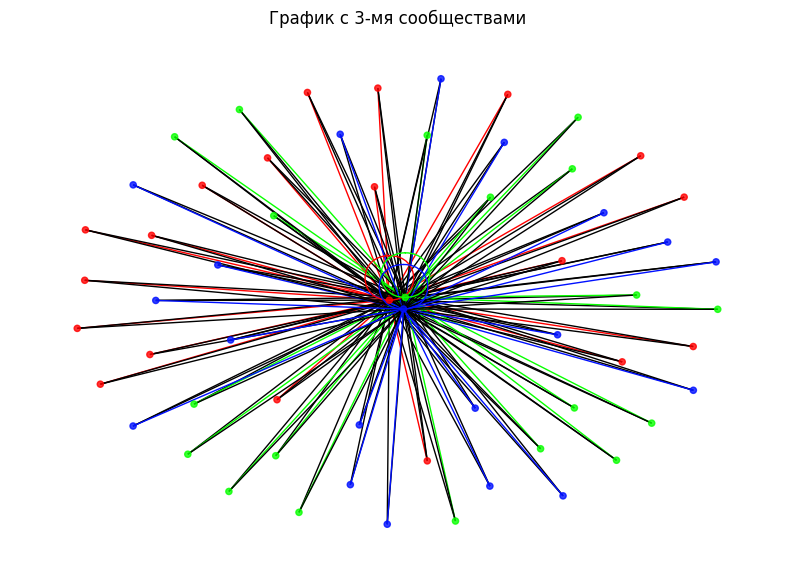

In [349]:
creator = GraphCreator(both=True)
G = creator.create_graph()
communities = list(nx.community.louvain_communities(G))[:3]
num_communities = len(communities)
print(f'Количество кластеров: {num_communities}')

node_colors, edge_colors = reformat_G_and_get_colors(G, communities)



plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1)
plt.title('График с 3-мя сообществами')
plt.axis('off');

Опять видим похожую картину

### Вывод

Что означают сообщества?

Каждая центральная точка относится к разному сообществу. Переферийные точки относятся к сообществу на основании того, с какими центральным точками они связаны. На основании этих данных можно понять, кем были приглашены какие пользователи.  